In [2]:
%load_ext autoreload
%autoreload 2

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk
from scipy.optimize import minimize
from astropy.wcs import WCS

In [99]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=13, 
    width=13, 
    do_pca=True, 
    do_psf=False,
    time_arr=time, 
    data_arr=tpfs, 
    err_arr=errs, 
    bkg_arr=bkgs, 
)
photometry_flux = sc.to_lightcurve().flux[sq][start:end]

In [177]:
data.psf_lightcurve(flux_arr=photometry_flux.value, model_name='Gaussian', bkg_mag_cutoff=10, verbose=True)

100%|██████████| 900/900 [04:08<00:00,  3.62it/s]
207659211621.77533
207659211621.77533
207659211621.77533
207659211621.77533
207659211621.77533
207659211621.77533
207659211621.77533
207659211621.77533


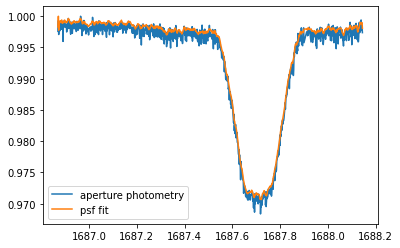

In [178]:
plt.plot(time, photometry_flux / np.max(photometry_flux), label='aperture photometry')
plt.plot(time, data.psf_flux[:end-start] / np.max(data.psf_flux[:end-start]), label='psf fit')
plt.legend()
plt.show()

In [115]:
gaussian_model = eleanor.models.Gaussian(
            shape=tpfs.shape[1:], 
            col_ref=0, 
            row_ref=0, 
            xc = [4.51646021, 4.3177313, 4.10392764],
            yc = [6.52438976, 2.51141035, 3.87952034],
            fit_idx = 2,
            bkg0 = bkgs[0]
        )

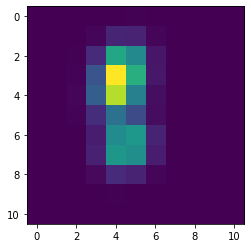

In [116]:
plt.imshow(gaussian_model.mean(np.max(tpfs[0]) * np.ones(3,), 0, 0, bkg0, [0.9, 0.1, 0.8]))

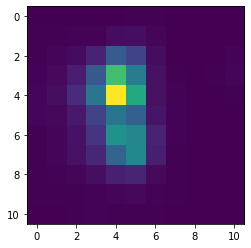

In [117]:
plt.imshow(tpfs[0])

In [120]:
model_tpf0 = gaussian_model.mean(np.max(tpfs[0]) * np.ones(3,), 0, 0, bkg0, [0.9, 0.1, 0.8])

In [171]:
from functools import reduce

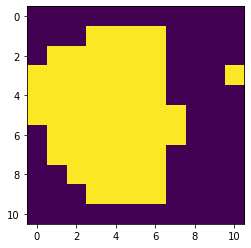

In [174]:
plt.imshow(reduce(np.bitwise_or, np.array([b < d for (b, d) in zip(bkgs, tpfs)])))